# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()

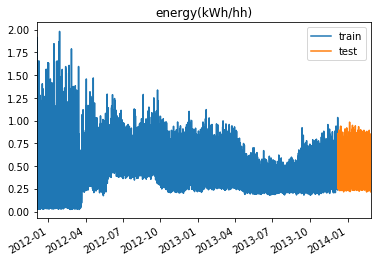

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

In [8]:
PERCENT_TEST_EXAMPLES = 0.5
# EPOCHS = 5
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'optuna_result'/ 'anp-rnn2'
name = 'anp-rnn2' # study name
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp-rnn2


In [28]:
def main(trial, train=True):    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name="anp-rnn", version=trial.number)

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        gradient_clip_val=trial.params["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.params['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LatentModelPL(trial.params)
    if train:
        trainer.fit(model)
    
    return model, trainer


def add_sugg(trial):
    
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    trial.suggest_categorical("hidden_dim", [8*2**i for i in range(6)])
    trial.suggest_categorical("latent_dim", [8*2**i for i in range(6)])
    
    trial.suggest_int("attention_layers", 1, 4)
    trial.suggest_categorical("n_latent_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_det_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_decoder_layers", [1, 2, 4, 8])

    trial.suggest_categorical("dropout", [0, 0.2, 0.5])
    trial.suggest_categorical("attention_dropout", [0, 0.2, 0.5])

    trial.suggest_categorical(
        "latent_enc_self_attn_type", ['uniform', 'multihead', 'ptmultihead']
    )
    trial.suggest_categorical("det_enc_self_attn_type",  ['uniform', 'multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_cross_attn_type", ['uniform', 'multihead', 'ptmultihead'])

    trial.suggest_categorical("batchnorm", [False, True])
    trial.suggest_categorical("use_self_attn", [False, True])
    trial.suggest_categorical("use_lvar", [False, True])
    trial.suggest_categorical("use_deterministic_path", [False, True])
    trial.suggest_categorical("use_rnn", [True, False])

    # training specific (for this model)
    trial.suggest_uniform("min_std", 0.005, 0.005)
    trial.suggest_int("grad_clip", 40, 40)
    trial.suggest_int("num_context", 24 * 4, 24 * 4)
    trial.suggest_int("num_extra_target", 24*4, 24*4)
    trial.suggest_int("max_nb_epochs", 10, 10)
    trial.suggest_int("num_workers", 3, 3)
    trial.suggest_int("batch_size", 16, 16)
    trial.suggest_int("num_heads", 8, 8)

    trial.suggest_int("x_dim", 17, 17)
    trial.suggest_int("y_dim", 1, 1)
    trial.suggest_int("vis_i", 670, 670)
    
    trial.suggest_categorical("context_in_target", [True, True])
    
    return trial

def objective(trial):
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    
    trial = add_sugg(trial)
    
    print('trial', trial.number, 'params', trial.params)
    
    
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    model, trainer = main(trial)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    
    return model.logger.metrics[-1]['val_loss']


# Default params

In [10]:
default_params = {
 'attention_dropout': 0,
 'attention_layers': 2,
 'batch_size': 16,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'dropout': 0,
 'grad_clip': 40,
 'hidden_dim': 128,
 'latent_dim': 128,
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 0.002,
 'max_nb_epochs': 10,
 'min_std': 0.005,
 'n_decoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_latent_encoder_layers': 2,
 'num_context': 24*4,
 'num_extra_target': 24*4,
 'num_heads': 8,
 'num_workers': 3,
 'use_deterministic_path': True,
 'use_lvar': True,
 'use_self_attn': True,
 'vis_i': '670',
 'x_dim': 17,
 'y_dim': 1,
 'use_rnn': False,
 'context_in_target': True
}

# Train ANP-RNN

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                   Name           Type Params
0                                 model    LatentModel    1 M
1                           model._lstm           LSTM  207 K
2                 model._latent_encoder  LatentEncoder   98 K
3    model._latent_encoder._input_layer         Linear   16 K
4        model._latent_encoder._encoder     ModuleList   32 K
..                                  ...            ...    ...
121    model._decoder._decoder.3.linear         Linear  147 K
122       model._decoder._decoder.3.act           ReLU    0  
123   model._decoder._decoder.3.dropout      Dropout2d    0  
124                model._decoder._mean         Linear  385  
125                 model._decoder._std         Linear  385  

[126 rows x 3 columns]


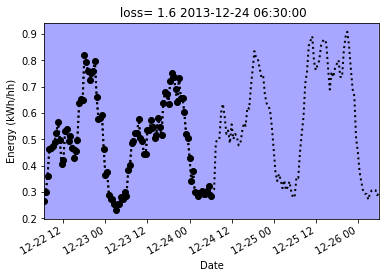

step 0, {'val_loss': '1.5693567991256714', 'val/kl': '0.5020207762718201', 'val/mse': '0.2388661950826645', 'val/std': '1.0383363962173462'}


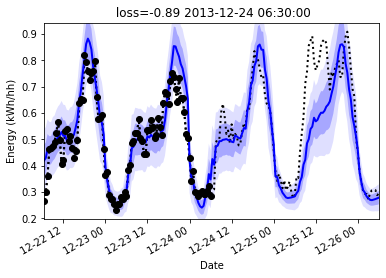

step 2194, {'val_loss': '0.5343308448791504', 'val/kl': '0.0009442351292818785', 'val/mse': '0.007357416208833456', 'val/std': '0.07601924240589142'}


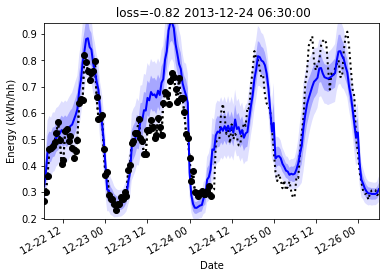

step 4389, {'val_loss': '-1.1690877676010132', 'val/kl': '0.00022915728914085776', 'val/mse': '0.005337832495570183', 'val/std': '0.049246110022068024'}


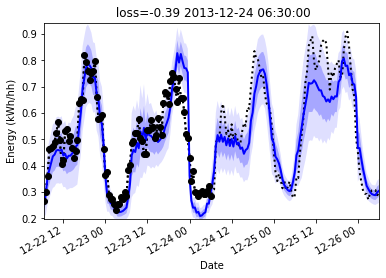

step 6584, {'val_loss': '-1.273390769958496', 'val/kl': '0.00022587954299524426', 'val/mse': '0.004663755185902119', 'val/std': '0.050486624240875244'}


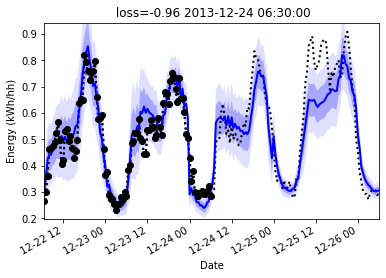

step 8779, {'val_loss': '-0.9049668312072754', 'val/kl': '0.000260441389400512', 'val/mse': '0.005967526696622372', 'val/std': '0.054492030292749405'}


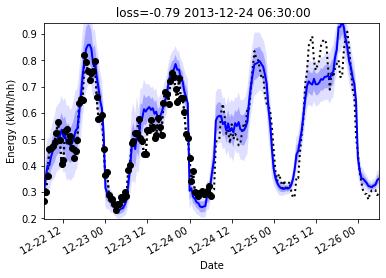

step 10974, {'val_loss': '-1.0017932653427124', 'val/kl': '0.0001905120152514428', 'val/mse': '0.004810153506696224', 'val/std': '0.0477420799434185'}


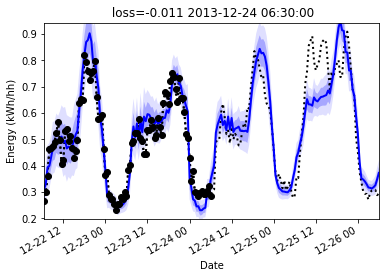

step 13169, {'val_loss': '-0.9930673241615295', 'val/kl': '0.0002287834940943867', 'val/mse': '0.004163599573075771', 'val/std': '0.037404779344797134'}
Epoch     5: reducing learning rate of group 0 to 2.0000e-04.


INFO:root:Epoch 00006: early stopping


INFO:root:
                                   Name           Type Params
0                                 model    LatentModel    1 M
1                           model._lstm           LSTM  207 K
2                 model._latent_encoder  LatentEncoder   98 K
3    model._latent_encoder._input_layer         Linear   16 K
4        model._latent_encoder._encoder     ModuleList   32 K
..                                  ...            ...    ...
121    model._decoder._decoder.3.linear         Linear  147 K
122       model._decoder._decoder.3.act           ReLU    0  
123   model._decoder._decoder.3.dropout      Dropout2d    0  
124                model._decoder._mean         Linear  385  
125                 model._decoder._std         Linear  385  

[126 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp-rnn2/anp-rnn/version_2/chk/_ckpt_epoch_2.ckpt


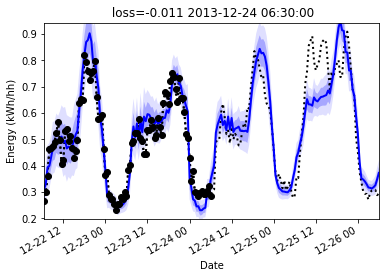

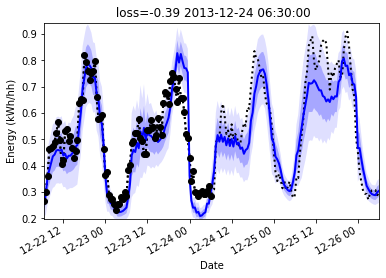

step 6584, {'val_loss': '-1.273390769958496', 'val/kl': '0.00022587954299524426', 'val/mse': '0.004663755185902119', 'val/std': '0.050486624240875244'}

None


In [11]:
name = 'anp-rnn'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'use_deterministic_path': True,
 'use_rnn': True
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 2

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

# ANP-RNN 2

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                  Name           Type Params
0                                model    LatentModel  798 K
1                          model._lstm           LSTM  207 K
2                model._latent_encoder  LatentEncoder   98 K
3   model._latent_encoder._input_layer         Linear   16 K
4       model._latent_encoder._encoder     ModuleList   32 K
..                                 ...            ...    ...
70    model._decoder._decoder.3.linear         Linear   65 K
71       model._decoder._decoder.3.act           ReLU    0  
72   model._decoder._decoder.3.dropout      Dropout2d    0  
73                model._decoder._mean         Linear  257  
74                 model._decoder._std         Linear  257  

[75 rows x 3 columns]


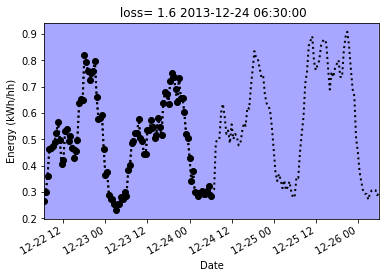

step 0, {'val_loss': '1.6190637350082397', 'val/kl': '0.5031337738037109', 'val/mse': '0.3089987337589264', 'val/std': '1.0617789030075073'}


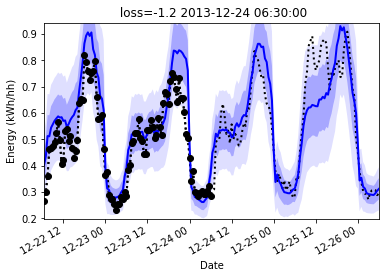

step 2194, {'val_loss': '-1.3857086896896362', 'val/kl': '0.00048115666140802205', 'val/mse': '0.004232240840792656', 'val/std': '0.07312013953924179'}


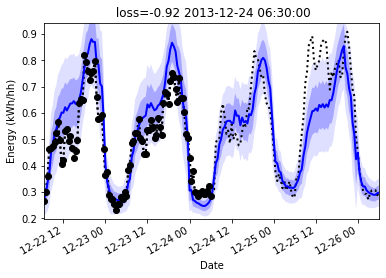

step 4389, {'val_loss': '-1.344988465309143', 'val/kl': '0.00020843140373472124', 'val/mse': '0.0055994573049247265', 'val/std': '0.07038313895463943'}


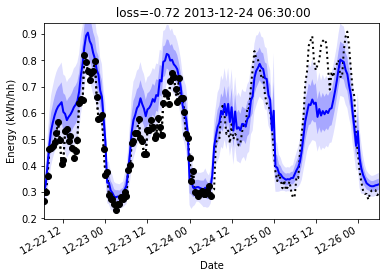

step 6584, {'val_loss': '-1.0654047727584839', 'val/kl': '0.0002335252647753805', 'val/mse': '0.006818015594035387', 'val/std': '0.06158881261944771'}


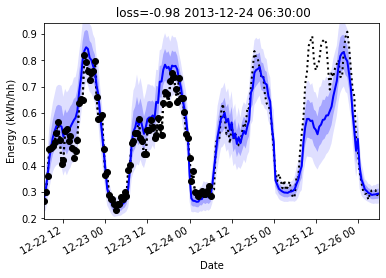

step 8779, {'val_loss': '-1.3153259754180908', 'val/kl': '0.00018677482148632407', 'val/mse': '0.003928155638277531', 'val/std': '0.046489667147397995'}
Epoch     3: reducing learning rate of group 0 to 2.0000e-04.


INFO:root:Epoch 00004: early stopping


INFO:root:
                                  Name           Type Params
0                                model    LatentModel  798 K
1                          model._lstm           LSTM  207 K
2                model._latent_encoder  LatentEncoder   98 K
3   model._latent_encoder._input_layer         Linear   16 K
4       model._latent_encoder._encoder     ModuleList   32 K
..                                 ...            ...    ...
70    model._decoder._decoder.3.linear         Linear   65 K
71       model._decoder._decoder.3.act           ReLU    0  
72   model._decoder._decoder.3.dropout      Dropout2d    0  
73                model._decoder._mean         Linear  257  
74                 model._decoder._std         Linear  257  

[75 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp-rnn2/anp-rnn3/version_2/chk/_ckpt_epoch_0.ckpt


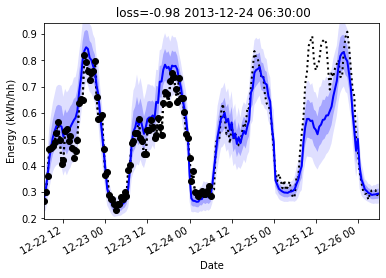

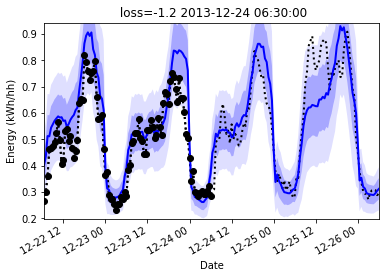

step 2194, {'val_loss': '-1.3857086896896362', 'val/kl': '0.00048115666140802205', 'val/mse': '0.004232240840792656', 'val/std': '0.07312013953924179'}

None


In [13]:
name = 'anp-rnn3'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'ptmultihead',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'use_deterministic_path': False,
 'use_rnn': True
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 2

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

In [14]:
# # plot lots of metrics
# loader = model.val_dataloader()[0]
# for i in range(0, len(loader), 10):
#     plot_from_loader(loader, model, i=i)
#     plt.show()

# ANP

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                   Name           Type Params
0                                 model    LatentModel    2 M
1                 model._latent_encoder  LatentEncoder  609 K
2    model._latent_encoder._input_layer         Linear    2 K
3        model._latent_encoder._encoder     ModuleList   32 K
4      model._latent_encoder._encoder.0  NPBlockRelu2d   16 K
..                                  ...            ...    ...
226    model._decoder._decoder.3.linear         Linear  147 K
227       model._decoder._decoder.3.act           ReLU    0  
228   model._decoder._decoder.3.dropout      Dropout2d    0  
229                model._decoder._mean         Linear  385  
230                 model._decoder._std         Linear  385  

[231 rows x 3 columns]


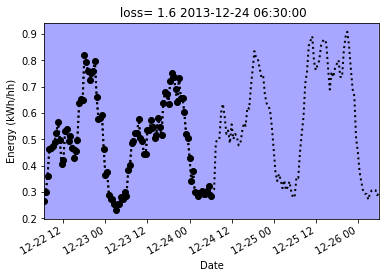

step 0, {'val_loss': '1.5840158462524414', 'val/kl': '0.4973420202732086', 'val/mse': '0.25478214025497437', 'val/std': '1.0546205043792725'}


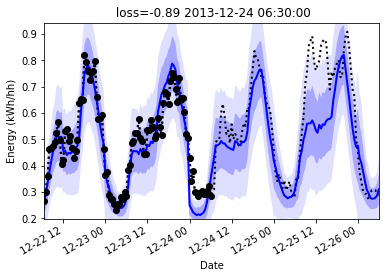

step 2194, {'val_loss': '-1.2122845649719238', 'val/kl': '0.0010215543443337083', 'val/mse': '0.007163152098655701', 'val/std': '0.07716882228851318'}


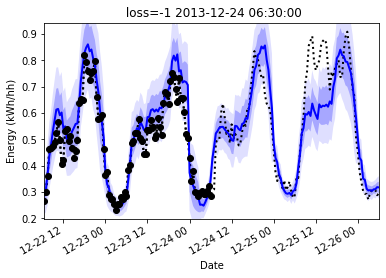

step 4389, {'val_loss': '-1.028235673904419', 'val/kl': '0.000353723211446777', 'val/mse': '0.005656410474330187', 'val/std': '0.05565137043595314'}


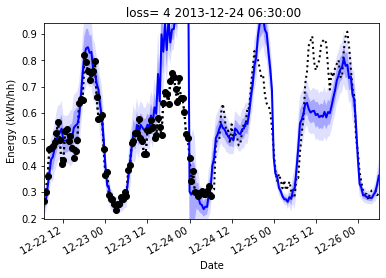

step 6584, {'val_loss': '-0.7582443356513977', 'val/kl': '0.0002442289551254362', 'val/mse': '0.0062664104625582695', 'val/std': '0.04417317360639572'}


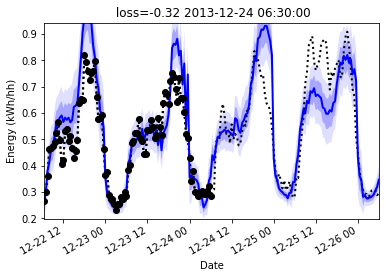

step 8779, {'val_loss': '-0.9393323659896851', 'val/kl': '0.0001381170586682856', 'val/mse': '0.007535985670983791', 'val/std': '0.05241641029715538'}
Epoch     3: reducing learning rate of group 0 to 2.0000e-04.


INFO:root:Epoch 00004: early stopping


INFO:root:
                                   Name           Type Params
0                                 model    LatentModel    2 M
1                 model._latent_encoder  LatentEncoder  609 K
2    model._latent_encoder._input_layer         Linear    2 K
3        model._latent_encoder._encoder     ModuleList   32 K
4      model._latent_encoder._encoder.0  NPBlockRelu2d   16 K
..                                  ...            ...    ...
226    model._decoder._decoder.3.linear         Linear  147 K
227       model._decoder._decoder.3.act           ReLU    0  
228   model._decoder._decoder.3.dropout      Dropout2d    0  
229                model._decoder._mean         Linear  385  
230                 model._decoder._std         Linear  385  

[231 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp-rnn2/anp/version_3/chk/_ckpt_epoch_0.ckpt


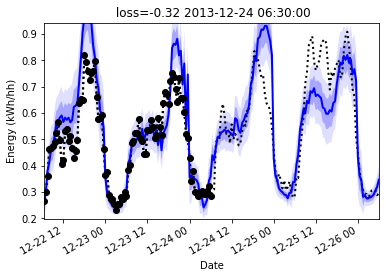

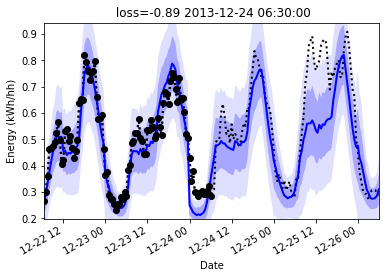

step 2194, {'val_loss': '-1.2122845649719238', 'val/kl': '0.0010215543443337083', 'val/mse': '0.007163152098655701', 'val/std': '0.07716882228851318'}

None


In [15]:
name = 'anp'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'multihead',
 'latent_enc_self_attn_type': 'multihead',
 'use_deterministic_path': True,
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 3

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

# NP

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                  Name           Type Params
0                                model    LatentModel  455 K
1                model._latent_encoder  LatentEncoder   84 K
2   model._latent_encoder._input_layer         Linear    2 K
3       model._latent_encoder._encoder     ModuleList   32 K
4     model._latent_encoder._encoder.0  NPBlockRelu2d   16 K
..                                 ...            ...    ...
67    model._decoder._decoder.3.linear         Linear   65 K
68       model._decoder._decoder.3.act           ReLU    0  
69   model._decoder._decoder.3.dropout      Dropout2d    0  
70                model._decoder._mean         Linear  257  
71                 model._decoder._std         Linear  257  

[72 rows x 3 columns]


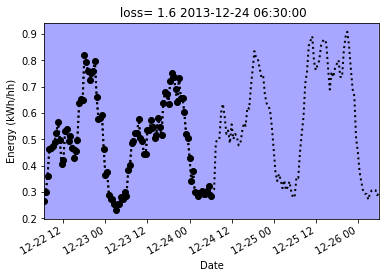

step 0, {'val_loss': '1.5374459028244019', 'val/kl': '0.4961514472961426', 'val/mse': '0.24871626496315002', 'val/std': '0.9974575042724609'}


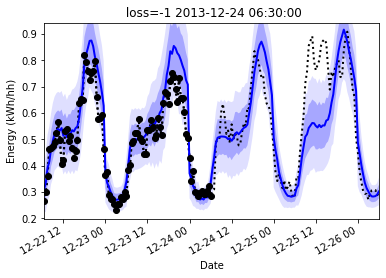

step 2194, {'val_loss': '-1.3054770231246948', 'val/kl': '0.0014658418949693441', 'val/mse': '0.004981751553714275', 'val/std': '0.059659067541360855'}


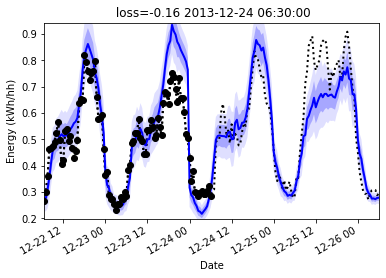

step 4389, {'val_loss': '-1.3078840970993042', 'val/kl': '0.0003726059221662581', 'val/mse': '0.004040098283439875', 'val/std': '0.04867682605981827'}


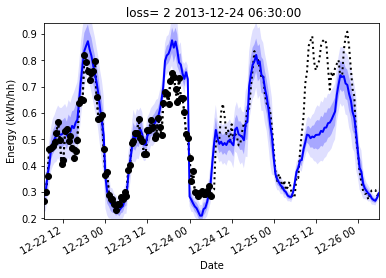

step 6584, {'val_loss': '-1.023400068283081', 'val/kl': '0.00030945712933316827', 'val/mse': '0.005101347342133522', 'val/std': '0.05553557351231575'}


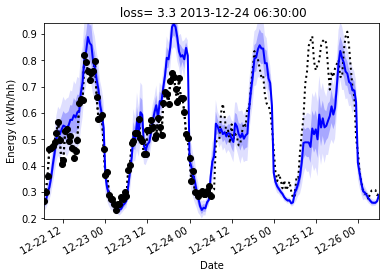

step 8779, {'val_loss': '-0.5684605836868286', 'val/kl': '0.00023415201576426625', 'val/mse': '0.004800163209438324', 'val/std': '0.03970134258270264'}


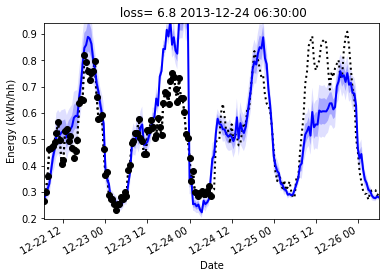

step 10974, {'val_loss': '0.206074520945549', 'val/kl': '0.0002613919787108898', 'val/mse': '0.0049077728763222694', 'val/std': '0.032850708812475204'}
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.


INFO:root:Epoch 00005: early stopping


INFO:root:
                                  Name           Type Params
0                                model    LatentModel  455 K
1                model._latent_encoder  LatentEncoder   84 K
2   model._latent_encoder._input_layer         Linear    2 K
3       model._latent_encoder._encoder     ModuleList   32 K
4     model._latent_encoder._encoder.0  NPBlockRelu2d   16 K
..                                 ...            ...    ...
67    model._decoder._decoder.3.linear         Linear   65 K
68       model._decoder._decoder.3.act           ReLU    0  
69   model._decoder._decoder.3.dropout      Dropout2d    0  
70                model._decoder._mean         Linear  257  
71                 model._decoder._std         Linear  257  

[72 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp-rnn2/np/version_2/chk/_ckpt_epoch_1.ckpt


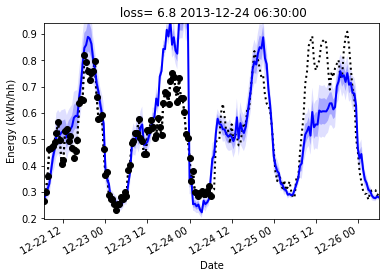

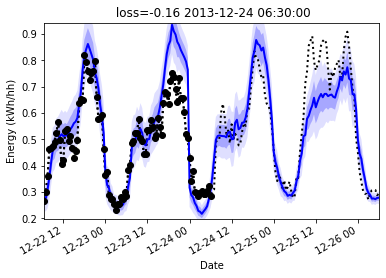

step 4389, {'val_loss': '-1.3078840970993042', 'val/kl': '0.0003726059221662581', 'val/mse': '0.004040098283439875', 'val/std': '0.04867682605981827'}

None


In [16]:
name = 'np'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'uniform',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
    'use_deterministic_path': False,
})
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial)
trial.number = 2

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(trial.params)

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

# Hyperparam

In [34]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args([])

pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()
name = 'anp-rnn1'
study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)


[I 2020-02-16 06:55:19,584] Using an existing study with name 'anp-rnn1' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('3d').total_seconds())

trial 29 params {'attention_dropout': 0.2, 'attention_layers': 2, 'batch_size': 16, 'batchnorm': True, 'context_in_target': True, 'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'multihead', 'dropout': 0, 'grad_clip': 40, 'hidden_dim': 32, 'latent_dim': 64, 'latent_enc_self_attn_type': 'ptmultihead', 'learning_rate': 0.0058703726639809896, 'max_nb_epochs': 10, 'min_std': 0.005, 'n_decoder_layers': 8, 'n_det_encoder_layers': 2, 'n_latent_encoder_layers': 8, 'num_context': 96, 'num_extra_target': 96, 'num_heads': 8, 'num_workers': 3, 'use_deterministic_path': False, 'use_lvar': True, 'use_rnn': True, 'use_self_attn': False, 'vis_i': 670, 'x_dim': 17, 'y_dim': 1}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                   Name           Type Params
0                                 model    LatentModel  118 K
1                           model._lstm           LSTM   14 K
2                 model._latent_encoder  LatentEncoder   15 K
3    model._latent_encoder._input_layer         Linear    1 K
4        model._latent_encoder._encoder     ModuleList    8 K
..                                  ...            ...    ...
118       model._decoder._decoder.7.act           ReLU    0  
119   model._decoder._decoder.7.dropout      Dropout2d    0  
120      model._decoder._decoder.7.norm    BatchNorm2d  192  
121                model._decoder._mean         Linear   97  
122                 model._decoder._std         Linear   97  

[123 rows x 3 columns]


step 0, {'val_loss': '1.5332967042922974', 'val/kl': '0.5003573894500732', 'val/mse': '0.3075014650821686', 'val/std': '0.9426979422569275'}


step 2194, {'val_loss': '-0.3435288369655609', 'val/kl': '0.0003237754572182894', 'val/mse': '0.02968326210975647', 'val/std': '0.16645464301109314'}


step 4389, {'val_loss': '-0.12076319754123688', 'val/kl': '0.0009134513093158603', 'val/mse': '0.017563801258802414', 'val/std': '0.08026392757892609'}


step 6584, {'val_loss': '-1.3186585903167725', 'val/kl': '0.0002568588824942708', 'val/mse': '0.005394966807216406', 'val/std': '0.06686413288116455'}


step 8779, {'val_loss': '-1.125415563583374', 'val/kl': '0.00019626482389867306', 'val/mse': '0.006910798605531454', 'val/std': '0.07083785533905029'}


step 10974, {'val_loss': '-1.391121506690979', 'val/kl': '0.0004129649605602026', 'val/mse': '0.004302750341594219', 'val/std': '0.06069936230778694'}


step 13169, {'val_loss': '-1.0961132049560547', 'val/kl': '0.0003247860004194081', 'val/mse': '0.006203540600836277', 'val/std': '0.05735539272427559'}


step 15364, {'val_loss': '-0.8419629335403442', 'val/kl': '0.00034610298462212086', 'val/mse': '0.005819730460643768', 'val/std': '0.05368044599890709'}


step 17559, {'val_loss': '-1.3719918727874756', 'val/kl': '0.00039435975486412644', 'val/mse': '0.0042431410402059555', 'val/std': '0.059302836656570435'}
Epoch     7: reducing learning rate of group 0 to 5.8704e-04.


step 19754, {'val_loss': '-1.5102424621582031', 'val/kl': '0.00029231738881208', 'val/mse': '0.0033912782091647387', 'val/std': '0.046705130487680435'}


step 21949, {'val_loss': '-1.423159122467041', 'val/kl': '0.00035497310454957187', 'val/mse': '0.0035869088023900986', 'val/std': '0.047349609434604645'}

logger.metrics [{'val_loss': -1.423159122467041, 'val/kl': 0.00035497310454957187, 'val/mse': 0.0035869088023900986, 'val/std': 0.047349609434604645, 'epoch': 9}]


[I 2020-02-16 07:44:25,994] Finished trial#29 resulted in value: -1.423159122467041. Current best value is -1.5058155059814453 with parameters: {'attention_dropout': 0.2, 'attention_layers': 1, 'batch_size': 16, 'batchnorm': True, 'context_in_target': True, 'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'multihead', 'dropout': 0, 'grad_clip': 40, 'hidden_dim': 32, 'latent_dim': 64, 'latent_enc_self_attn_type': 'ptmultihead', 'learning_rate': 0.008663362578308754, 'max_nb_epochs': 10, 'min_std': 0.005, 'n_decoder_layers': 8, 'n_det_encoder_layers': 2, 'n_latent_encoder_layers': 2, 'num_context': 96, 'num_extra_target': 96, 'num_heads': 8, 'num_workers': 3, 'use_deterministic_path': False, 'use_lvar': True, 'use_rnn': False, 'use_self_attn': False, 'vis_i': 670, 'x_dim': 17, 'y_dim': 1}.


trial 30 params {'attention_dropout': 0.2, 'attention_layers': 2, 'batch_size': 16, 'batchnorm': True, 'context_in_target': True, 'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'multihead', 'dropout': 0, 'grad_clip': 40, 'hidden_dim': 32, 'latent_dim': 64, 'latent_enc_self_attn_type': 'ptmultihead', 'learning_rate': 0.0022419054847050398, 'max_nb_epochs': 10, 'min_std': 0.005, 'n_decoder_layers': 8, 'n_det_encoder_layers': 2, 'n_latent_encoder_layers': 2, 'num_context': 96, 'num_extra_target': 96, 'num_heads': 8, 'num_workers': 3, 'use_deterministic_path': False, 'use_lvar': False, 'use_rnn': False, 'use_self_attn': False, 'vis_i': 670, 'x_dim': 17, 'y_dim': 1}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                  Name           Type Params
0                                model    LatentModel   94 K
1                model._latent_encoder  LatentEncoder    8 K
2   model._latent_encoder._input_layer         Linear  608  
3       model._latent_encoder._encoder     ModuleList    2 K
4     model._latent_encoder._encoder.0  NPBlockRelu2d    1 K
..                                 ...            ...    ...
87       model._decoder._decoder.7.act           ReLU    0  
88   model._decoder._decoder.7.dropout      Dropout2d    0  
89      model._decoder._decoder.7.norm    BatchNorm2d  192  
90                model._decoder._mean         Linear   97  
91                 model._decoder._std         Linear   97  

[92 rows x 3 columns]


step 0, {'val_loss': '0.7910884022712708', 'val/kl': '0.00010800049494719133', 'val/mse': '0.2537727653980255', 'val/std': '0.654058575630188'}


step 2194, {'val_loss': '-1.1204354763031006', 'val/kl': '0.0014955311780795455', 'val/mse': '0.00617215083912015', 'val/std': '0.09348662197589874'}


step 4389, {'val_loss': '-1.3880571126937866', 'val/kl': '0.0010640228865668178', 'val/mse': '0.004546670243144035', 'val/std': '0.06830815225839615'}


step 6584, {'val_loss': '-1.3446733951568604', 'val/kl': '0.0006483710603788495', 'val/mse': '0.005048147868365049', 'val/std': '0.06271157413721085'}


step 8779, {'val_loss': '-1.5619605779647827', 'val/kl': '0.0007974352920427918', 'val/mse': '0.003406693460419774', 'val/std': '0.05695287138223648'}


step 10974, {'val_loss': '-1.567822813987732', 'val/kl': '0.0007052362198010087', 'val/mse': '0.0034684455022215843', 'val/std': '0.0511687695980072'}


step 13169, {'val_loss': '-1.469671368598938', 'val/kl': '0.0006657325429841876', 'val/mse': '0.0036809651646763086', 'val/std': '0.04665883630514145'}


step 15364, {'val_loss': '-1.4495060443878174', 'val/kl': '0.0009186150855384767', 'val/mse': '0.003881386946886778', 'val/std': '0.04494263231754303'}


step 17559, {'val_loss': '-1.4232021570205688', 'val/kl': '0.0007268059998750687', 'val/mse': '0.0037214024923741817', 'val/std': '0.04474468529224396'}
Epoch     7: reducing learning rate of group 0 to 2.2419e-04.


step 19754, {'val_loss': '-1.4388623237609863', 'val/kl': '0.0007217807578854263', 'val/mse': '0.003411452053114772', 'val/std': '0.03921413794159889'}


step 21949, {'val_loss': '-1.4176470041275024', 'val/kl': '0.0006476619746536016', 'val/mse': '0.003419178072363138', 'val/std': '0.03866790235042572'}

logger.metrics [{'val_loss': -1.4176470041275024, 'val/kl': 0.0006476619746536016, 'val/mse': 0.003419178072363138, 'val/std': 0.03866790235042572, 'epoch': 9}]


[I 2020-02-16 08:18:44,472] Finished trial#30 resulted in value: -1.4176470041275024. Current best value is -1.5058155059814453 with parameters: {'attention_dropout': 0.2, 'attention_layers': 1, 'batch_size': 16, 'batchnorm': True, 'context_in_target': True, 'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'multihead', 'dropout': 0, 'grad_clip': 40, 'hidden_dim': 32, 'latent_dim': 64, 'latent_enc_self_attn_type': 'ptmultihead', 'learning_rate': 0.008663362578308754, 'max_nb_epochs': 10, 'min_std': 0.005, 'n_decoder_layers': 8, 'n_det_encoder_layers': 2, 'n_latent_encoder_layers': 2, 'num_context': 96, 'num_extra_target': 96, 'num_heads': 8, 'num_workers': 3, 'use_deterministic_path': False, 'use_lvar': True, 'use_rnn': False, 'use_self_attn': False, 'vis_i': 670, 'x_dim': 17, 'y_dim': 1}.


trial 31 params {'attention_dropout': 0, 'attention_layers': 3, 'batch_size': 16, 'batchnorm': True, 'context_in_target': True, 'det_enc_cross_attn_type': 'multihead', 'det_enc_self_attn_type': 'multihead', 'dropout': 0, 'grad_clip': 40, 'hidden_dim': 32, 'latent_dim': 64, 'latent_enc_self_attn_type': 'ptmultihead', 'learning_rate': 0.0065892056326513826, 'max_nb_epochs': 10, 'min_std': 0.005, 'n_decoder_layers': 8, 'n_det_encoder_layers': 2, 'n_latent_encoder_layers': 2, 'num_context': 96, 'num_extra_target': 96, 'num_heads': 8, 'num_workers': 3, 'use_deterministic_path': False, 'use_lvar': True, 'use_rnn': False, 'use_self_attn': False, 'vis_i': 670, 'x_dim': 17, 'y_dim': 1}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                   Name           Type Params
0                                 model    LatentModel  124 K
1                 model._latent_encoder  LatentEncoder    8 K
2    model._latent_encoder._input_layer         Linear  608  
3        model._latent_encoder._encoder     ModuleList    2 K
4      model._latent_encoder._encoder.0  NPBlockRelu2d    1 K
..                                  ...            ...    ...
146       model._decoder._decoder.7.act           ReLU    0  
147   model._decoder._decoder.7.dropout      Dropout2d    0  
148      model._decoder._decoder.7.norm    BatchNorm2d  192  
149                model._decoder._mean         Linear   97  
150                 model._decoder._std         Linear   97  

[151 rows x 3 columns]


step 0, {'val_loss': '1.5510637760162354', 'val/kl': '0.504607617855072', 'val/mse': '0.33672571182250977', 'val/std': '0.9382523894309998'}


step 2194, {'val_loss': '-0.9993453621864319', 'val/kl': '0.00492581631988287', 'val/mse': '0.0076696309261024', 'val/std': '0.10437598824501038'}


step 4389, {'val_loss': '-1.3951125144958496', 'val/kl': '0.0013331789523363113', 'val/mse': '0.004176048096269369', 'val/std': '0.05822036787867546'}


step 6584, {'val_loss': '-1.4472817182540894', 'val/kl': '0.001394702005200088', 'val/mse': '0.0040388815104961395', 'val/std': '0.05575721710920334'}


step 8779, {'val_loss': '-1.4240511655807495', 'val/kl': '0.0011677203001454473', 'val/mse': '0.003808689536526799', 'val/std': '0.05027220398187637'}


step 10974, {'val_loss': '-1.51090669631958', 'val/kl': '0.001719470601528883', 'val/mse': '0.0037067916709929705', 'val/std': '0.05691952630877495'}


step 13169, {'val_loss': '-1.556814193725586', 'val/kl': '0.0011921778786927462', 'val/mse': '0.003143388545140624', 'val/std': '0.04716252535581589'}


step 15364, {'val_loss': '-1.5254632234573364', 'val/kl': '0.0011767667019739747', 'val/mse': '0.003485812107101083', 'val/std': '0.048899002373218536'}


step 17559, {'val_loss': '-1.4824448823928833', 'val/kl': '0.0012150286929681897', 'val/mse': '0.0035667528863996267', 'val/std': '0.0452319011092186'}


step 19754, {'val_loss': '-1.4969969987869263', 'val/kl': '0.0013163189869374037', 'val/mse': '0.00328625226393342', 'val/std': '0.04428704082965851'}
Epoch     8: reducing learning rate of group 0 to 6.5892e-04.


step 21949, {'val_loss': '-1.4131932258605957', 'val/kl': '0.0012195135932415724', 'val/mse': '0.0033923806622624397', 'val/std': '0.0400848314166069'}

logger.metrics [{'val_loss': -1.4131932258605957, 'val/kl': 0.0012195135932415724, 'val/mse': 0.0033923806622624397, 'val/std': 0.0400848314166069, 'epoch': 9}]


[I 2020-02-16 08:47:42,528] Finished trial#31 resulted in value: -1.4131932258605957. Current best value is -1.5058155059814453 with parameters: {'attention_dropout': 0.2, 'attention_layers': 1, 'batch_size': 16, 'batchnorm': True, 'context_in_target': True, 'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'multihead', 'dropout': 0, 'grad_clip': 40, 'hidden_dim': 32, 'latent_dim': 64, 'latent_enc_self_attn_type': 'ptmultihead', 'learning_rate': 0.008663362578308754, 'max_nb_epochs': 10, 'min_std': 0.005, 'n_decoder_layers': 8, 'n_det_encoder_layers': 2, 'n_latent_encoder_layers': 2, 'num_context': 96, 'num_extra_target': 96, 'num_heads': 8, 'num_workers': 3, 'use_deterministic_path': False, 'use_lvar': True, 'use_rnn': False, 'use_self_attn': False, 'vis_i': 670, 'x_dim': 17, 'y_dim': 1}.


trial 32 params {'attention_dropout': 0.2, 'attention_layers': 2, 'batch_size': 16, 'batchnorm': True, 'context_in_target': True, 'det_enc_cross_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'multihead', 'dropout': 0, 'grad_clip': 40, 'hidden_dim': 32, 'latent_dim': 64, 'latent_enc_self_attn_type': 'multihead', 'learning_rate': 0.004388551085821375, 'max_nb_epochs': 10, 'min_std': 0.005, 'n_decoder_layers': 8, 'n_det_encoder_layers': 4, 'n_latent_encoder_layers': 8, 'num_context': 96, 'num_extra_target': 96, 'num_heads': 8, 'num_workers': 3, 'use_deterministic_path': False, 'use_lvar': True, 'use_rnn': False, 'use_self_attn': False, 'vis_i': 670, 'x_dim': 17, 'y_dim': 1}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                   Name           Type Params
0                                 model    LatentModel  102 K
1                 model._latent_encoder  LatentEncoder   14 K
2    model._latent_encoder._input_layer         Linear  608  
3        model._latent_encoder._encoder     ModuleList    8 K
4      model._latent_encoder._encoder.0  NPBlockRelu2d    1 K
..                                  ...            ...    ...
127       model._decoder._decoder.7.act           ReLU    0  
128   model._decoder._decoder.7.dropout      Dropout2d    0  
129      model._decoder._decoder.7.norm    BatchNorm2d  192  
130                model._decoder._mean         Linear   97  
131                 model._decoder._std         Linear   97  

[132 rows x 3 columns]


step 0, {'val_loss': '1.6433210372924805', 'val/kl': '0.502083420753479', 'val/mse': '0.3020164668560028', 'val/std': '1.1032137870788574'}


step 2194, {'val_loss': '-0.5562781095504761', 'val/kl': '0.004524527583271265', 'val/mse': '0.01594124175608158', 'val/std': '0.20407840609550476'}


step 4389, {'val_loss': '-1.2800618410110474', 'val/kl': '0.001454153680242598', 'val/mse': '0.004913512151688337', 'val/std': '0.07995617389678955'}


step 6584, {'val_loss': '-1.4909727573394775', 'val/kl': '0.0005825856351293623', 'val/mse': '0.0038258214481174946', 'val/std': '0.05889587849378586'}


step 8779, {'val_loss': '-1.4236963987350464', 'val/kl': '0.0012530366657301784', 'val/mse': '0.0038965647108852863', 'val/std': '0.051243484020233154'}


step 10974, {'val_loss': '-1.4802192449569702', 'val/kl': '0.0008309829281643033', 'val/mse': '0.0034029236994683743', 'val/std': '0.05015803128480911'}


step 13169, {'val_loss': '1679.2408447265625', 'val/kl': '1679.53564453125', 'val/mse': '606.5656127929688', 'val/std': '752.9714965820312'}
Epoch     5: reducing learning rate of group 0 to 4.3886e-04.


step 15364, {'val_loss': '-1.515012502670288', 'val/kl': '0.0006384316366165876', 'val/mse': '0.0032132412306964397', 'val/std': '0.04366536810994148'}


step 17559, {'val_loss': '23501292.0', 'val/kl': '23501292.0', 'val/mse': '8748267.0', 'val/std': '6837.646484375'}


step 19754, {'val_loss': '-1.4798544645309448', 'val/kl': '0.0004828128730878234', 'val/mse': '0.0033622710034251213', 'val/std': '0.04285237193107605'}


In [25]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

Number of finished trials: 2
Best trial:


ValueError: Record does not exist.

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T